# Superstore Sales Forecasting with Prophet

In [1]:
# Import necessary libraries for data manipulation, numerical operations, and visualization

import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the dataset from the specified CSV file path
data= pd.read_csv(r'C:\Users\Olga\Desktop\save in one\Sample - Superstore.csv')
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [3]:
# Convert 'Order Date' and 'Ship Date' columns to datetime objects for time series analysis
data['Order Date']=pd.to_datetime(data['Order Date'])
data['Ship Date']=pd.to_datetime(data['Ship Date'])

# Import Additional Time Series Tools
# Prepare Daily Data, Fit Prophet Model, Forecast, and Plot

In [4]:
!pip install prophet


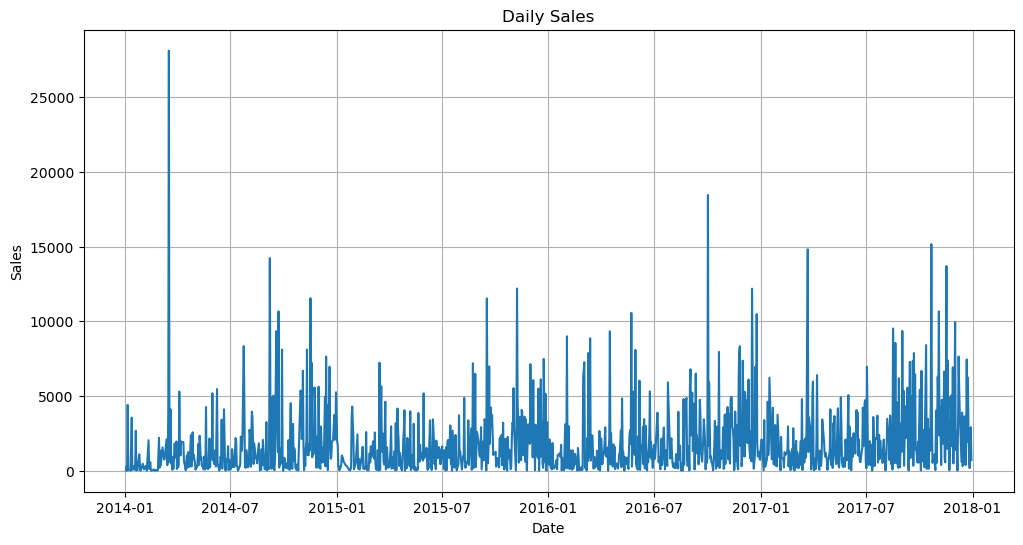

15:12:29 - cmdstanpy - INFO - Chain [1] start processing
15:12:31 - cmdstanpy - INFO - Chain [1] done processing


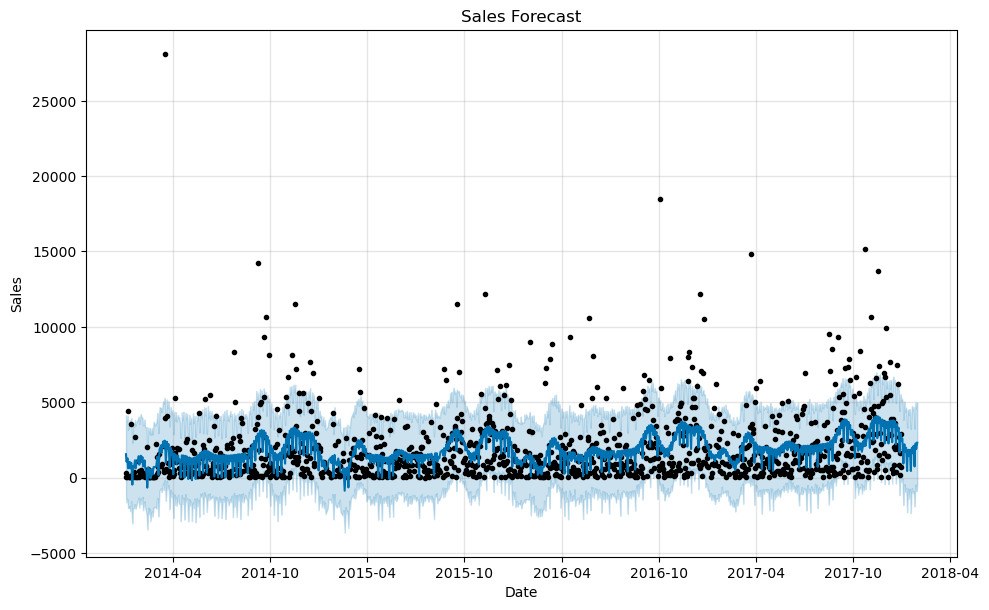

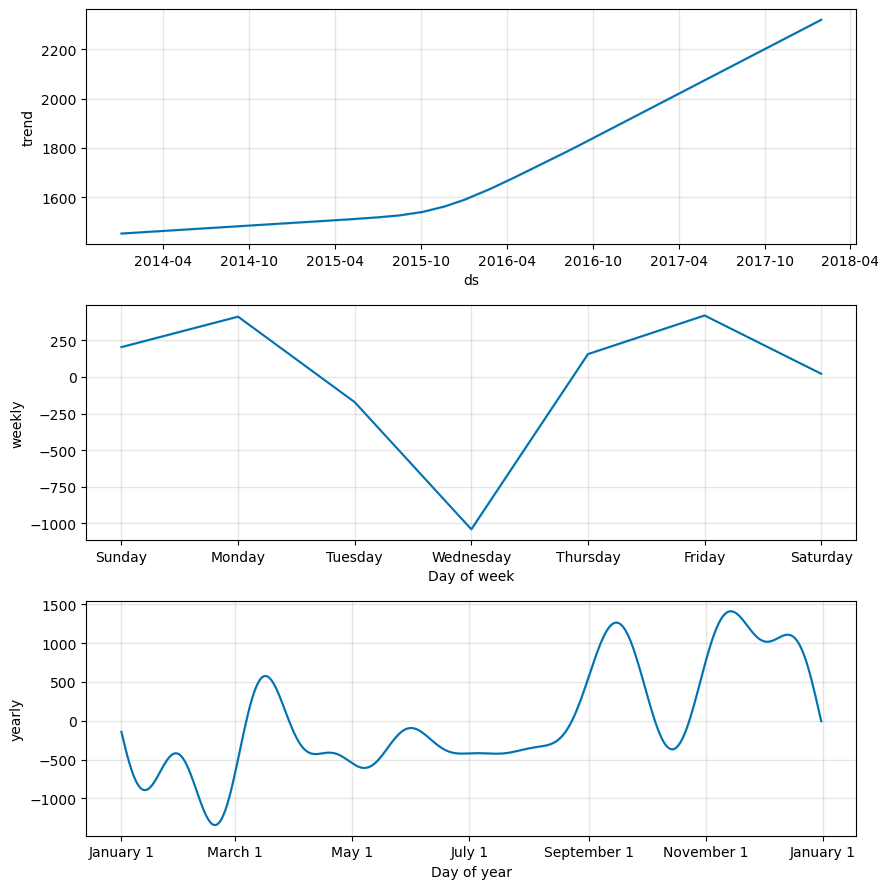

In [5]:
# Import the Prophet library
from prophet import Prophet


# Sort by date (good practice)
data = data.sort_values('Order Date')

# Aggregate sales by day
ts_sales = data.groupby('Order Date')['Sales'].sum().reset_index()

# Rename columns for compatibility with Prophet
ts_sales.columns = ['ds', 'y']

# Visualize the daily time series
plt.figure(figsize=(12, 6))
plt.plot(ts_sales['ds'], ts_sales['y'])
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Create and train the Prophet model on the entire daily sales data
model = Prophet()
model.fit(ts_sales)

# Forecast 30 days into the future
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Visualize the forecast
fig = model.plot(forecast)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Visualize the forecast components
fig2 = model.plot_components(forecast)
plt.show()

In [25]:
# Define the training set (all daily data except the last 6 points)
train = ts_sales[:-6]
# Define the test set (last 7 daily data points for plotting overlap)
test = ts_sales[-7:]

In [26]:
#Extract Actual and Predicted Values (from Daily Model)
actual_data_train = train['y']
actual_data_test = test['y']
fitted_data = forecast['yhat'][:-6]
forecast_data = forecast['yhat'][-7:]

 # Fit Prophet on Training Data (Daily) and Predict Monthly Future (Using Original Model) 

In [27]:
prophet_model = Prophet()
prophet_model.fit(train)

future = model.make_future_dataframe(periods=6, freq='ME')
forecast = model.predict(future)

15:42:24 - cmdstanpy - INFO - Chain [1] start processing
15:42:24 - cmdstanpy - INFO - Chain [1] done processing


# Prepare Monthly Data, Fit Prophet, Forecast, and Plot (Monthly)

In [11]:
# --- Step 1: Aggregate data monthly ---
# Set 'Order Date' as the index for resampling
data_indexed = data.set_index('Order Date')

# Aggregate sales by month end ('ME'), calculating the sum
ts_monthly = data_indexed['Sales'].resample('ME').sum()

# Reset the index to get the 'ds' column
ts_monthly = ts_monthly.reset_index()

# Rename columns for compatibility with Prophet
ts_monthly.columns = ['ds', 'y']

# Ensure the 'ds' column is still datetime (usually is, but for safety)
ts_monthly['ds'] = pd.to_datetime(ts_monthly['ds'])
ts_monthly = ts_monthly.sort_values('ds') # Sort just in case

print("Data aggregated by month:")
print(ts_monthly.head())
print(f"\nTotal {len(ts_monthly)} observations.")

# --- Step 2: Split data ---
# Split data into training and testing sets (for monthly data)
train_size_monthly = int(len(ts_monthly) * 0.8)
train_monthly, test_monthly = ts_monthly.iloc[:train_size_monthly], ts_monthly.iloc[train_size_monthly:]

print(f"\nTraining set size (monthly): {len(train_monthly)}")
print(f"Test set size (monthly): {len(test_monthly)}")

# --- Step 3: Create and train the Prophet model ---
# Create a NEW model for monthly data
model_monthly = Prophet()
model_monthly.fit(train_monthly)

# --- Step 4: Forecast ---
# Create a future dataframe with MONTHLY frequency ('ME')
future_monthly = model_monthly.make_future_dataframe(periods=len(test_monthly), freq='ME')
forecast_monthly = model_monthly.predict(future_monthly)

# --- Step 5: Extract data for visualization ---
# Data from the training set
actual_data_train_monthly = train_monthly['y']
# Predicted values for the training set
fitted_data_monthly = forecast_monthly['yhat'].iloc[:train_size_monthly]
# Actual data from the test set
actual_data_test_monthly = test_monthly['y']
# Predicted values for the test set
forecast_data_monthly = forecast_monthly['yhat'].iloc[train_size_monthly:]



Data aggregated by month:
          ds          y
0 2014-01-31  14236.895
1 2014-02-28   4519.892
2 2014-03-31  55691.009
3 2014-04-30  28295.345
4 2014-05-31  23648.287

Total 48 observations.

Training set size (monthly): 38
Test set size (monthly): 10


15:17:25 - cmdstanpy - INFO - Chain [1] start processing
15:17:25 - cmdstanpy - INFO - Chain [1] done processing


# Visualization of Forecast Sales

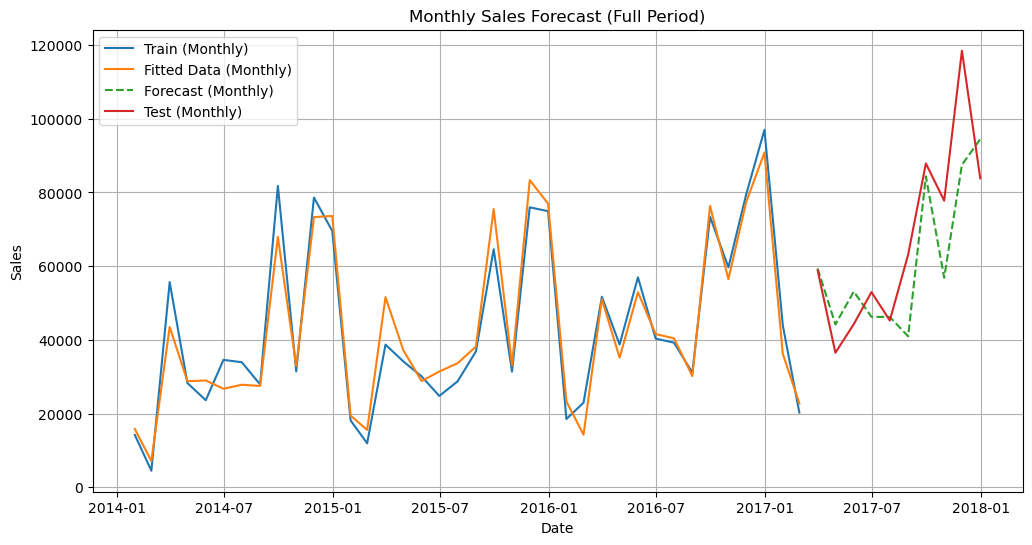

(17348.0, 17531.0)

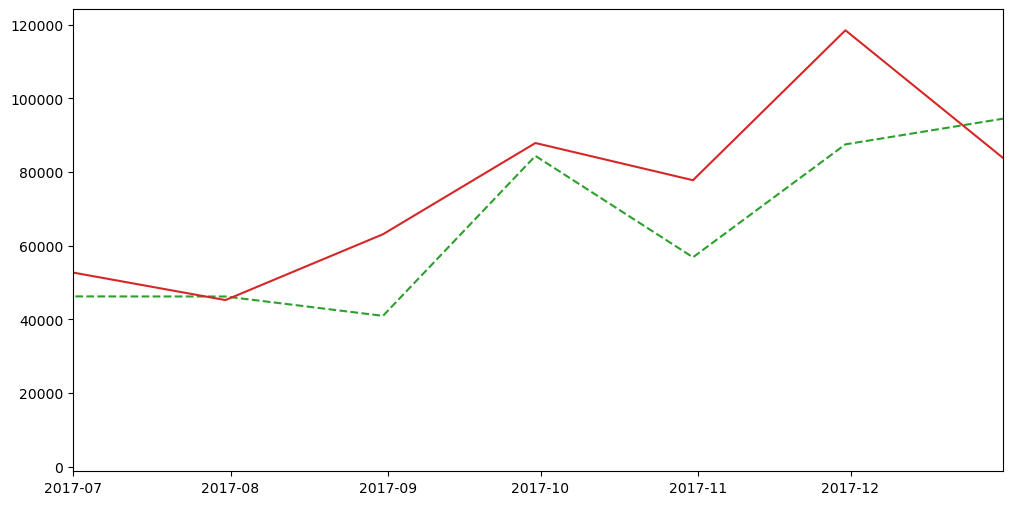

In [13]:
# --- Step 6: Visualize (two plots) ---

# --- PLOT 1: FULL PERIOD (Monthly Data) ---
plt.figure(figsize=(12, 6))
plt.plot(train_monthly['ds'], actual_data_train_monthly, label='Train (Monthly)')
plt.plot(train_monthly['ds'], fitted_data_monthly, label='Fitted Data (Monthly)')
# Use dates from forecast_monthly for the forecast line
plt.plot(forecast_monthly['ds'].iloc[train_size_monthly:], forecast_data_monthly, label="Forecast (Monthly)", linestyle='--')
plt.plot(test_monthly['ds'], actual_data_test_monthly, label='Test (Monthly)')
plt.title('Monthly Sales Forecast (Full Period)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


# --- PLOT 2: ZOOMED-IN PERIOD (Monthly Data from 2017-07) ---
plt.figure(figsize=(12, 6)) # New figure

# Plot the same lines again
plt.plot(train_monthly['ds'], actual_data_train_monthly, label='Train (Monthly)')
plt.plot(train_monthly['ds'], fitted_data_monthly, label='Fitted Data (Monthly)')
plt.plot(forecast_monthly['ds'].iloc[train_size_monthly:], forecast_data_monthly, label="Forecast (Monthly)", linestyle='--')
plt.plot(test_monthly['ds'], actual_data_test_monthly, label='Test (Monthly)')

# Set limits for the X-axis
start_date_zoom = pd.to_datetime('2017-07-01')
# End date is the last date in the forecast
end_date_zoom = forecast_monthly['ds'].iloc[-1]
plt.xlim(left=start_date_zoom, right=end_date_zoom)

 # Show the second, zoomed-in plot